# Creating your own dataset from Google Images

*by: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

In this tutorial we will see how to easily create an image dataset through Google Images. **Note**: You will have to repeat these steps for any new category you want to Google (e.g once for dogs and once for cats).

In [1]:
from fastai.vision import *

In [2]:
path = Path('../data/DS_July18/data_skeleton_2classes_nomirror_skeleton_only/train').resolve()

np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [3]:
# ImageDataBunch??

In [4]:
data.classes

['non_selfie', 'selfie']

In [5]:
# data.show_batch(rows=3, figsize=(7,8))

In [6]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['non_selfie', 'selfie'], 2, 2890, 722)

In [7]:
x, y = next(iter(data.valid_ds))

x.shape

torch.Size([3, 224, 224])

## Train model

In [8]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


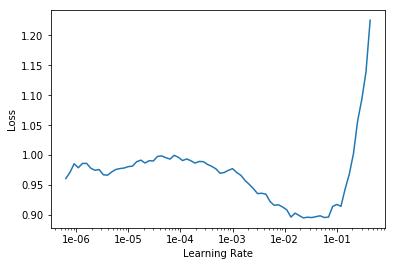

In [16]:
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(10, 1e-3)

In [18]:
learn.save('stage-1')

In [19]:
learn.unfreeze()

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


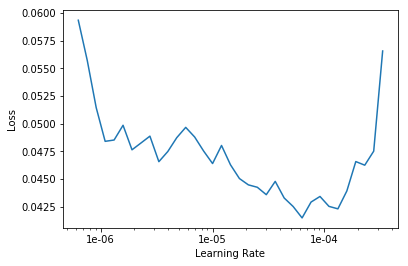

In [14]:
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(2, max_lr=slice(.6e-5,.6e-5/3))

In [22]:
learn.save('stage-2')

In [23]:
learn.fit_one_cycle(2, max_lr=slice(.6e-5,.6e-5/3))

In [25]:
learn.save('stage-3')
learn.fit_one_cycle(5, max_lr=slice(.6e-5,.6e-5/3))

In [26]:
learn.save('stage-4');
learn.fit_one_cycle(5, max_lr=slice(.6e-5,.6e-5/3))

In [27]:
learn.save('stage-5');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


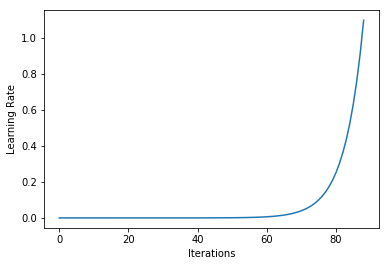

In [28]:
learn.lr_find()
learn.recorder.plot_lr()

In [19]:
# learn.save('stage-3')

## Interpretation

In [29]:
interp = ClassificationInterpretation.from_learner(learn)

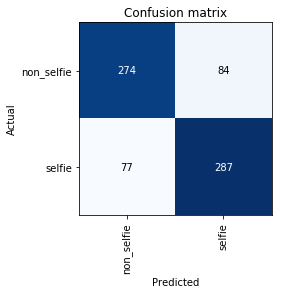

In [30]:
interp.plot_confusion_matrix()

In [31]:
confusion_mat = interp.confusion_matrix()
confusion_mat/np.sum(confusion_mat, axis = 1).reshape(-1,1)

array([[0.765363, 0.234637],
       [0.211538, 0.788462]])

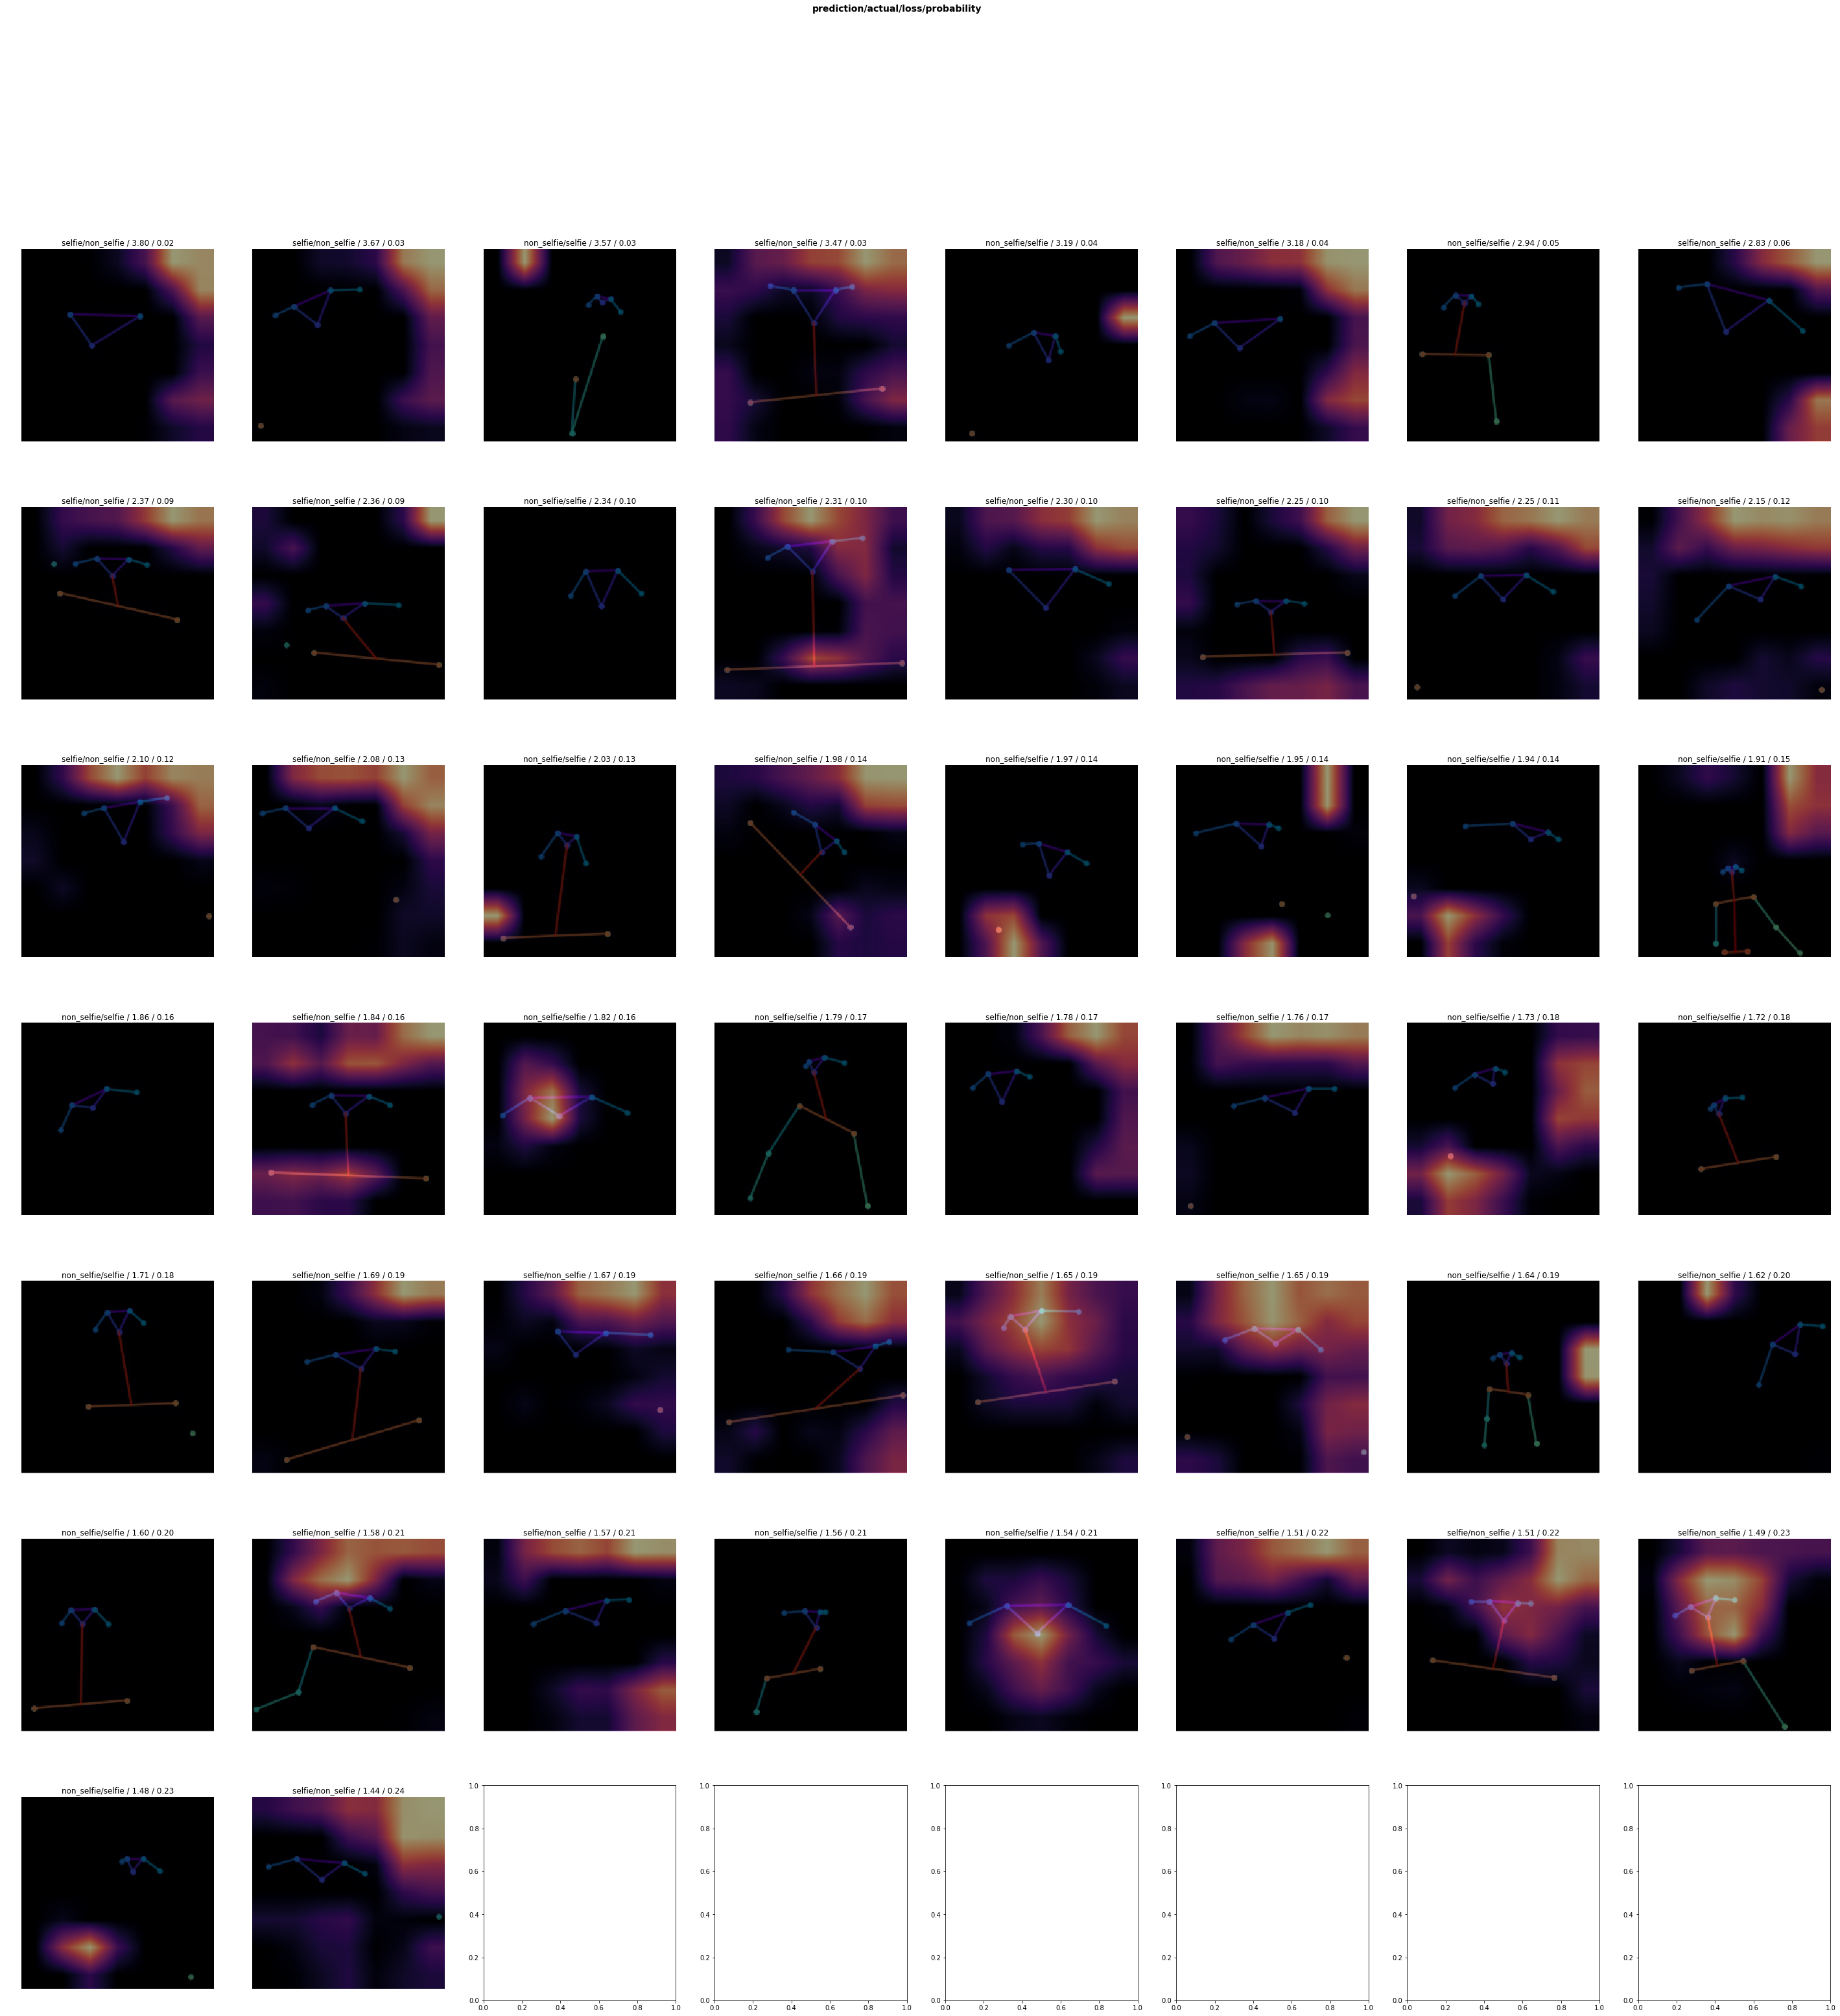

In [32]:
interp.plot_top_losses(50, figsize=(50,50))

In [25]:
path = Path('../data/DS_July18/data_4classes/').resolve()

data_test = (ImageList.from_folder(path)
        .split_by_folder(train='train', valid='test')
        .label_from_folder()
        .transform(get_transforms())
        .databunch()
        .normalize(imagenet_stats)
       ) 

In [26]:
data_test.classes, data_test.c, len(data_test.train_ds), len(data_test.valid_ds)

(['mirror_selfie__confirmed_224x224',
  'non_mirror_selfie__confirmed_224x224',
  'non_selfie__confirmed_224x224',
  'selfie__confirmed_224x224'],
 4,
 5811,
 15826)

In [27]:
res = learn.validate(dl = data_test.valid_dl, metrics=[error_rate, accuracy])

In [28]:
res #=> loss, error_rate, accuracy [metric]

[0.75239086, tensor(0.1343), tensor(0.8657)]

In [ ]:
interp = ClassificationInterpretation.from_learner(learn, ds_type = DatasetType.Train)
interp.plot_confusion_matrix()

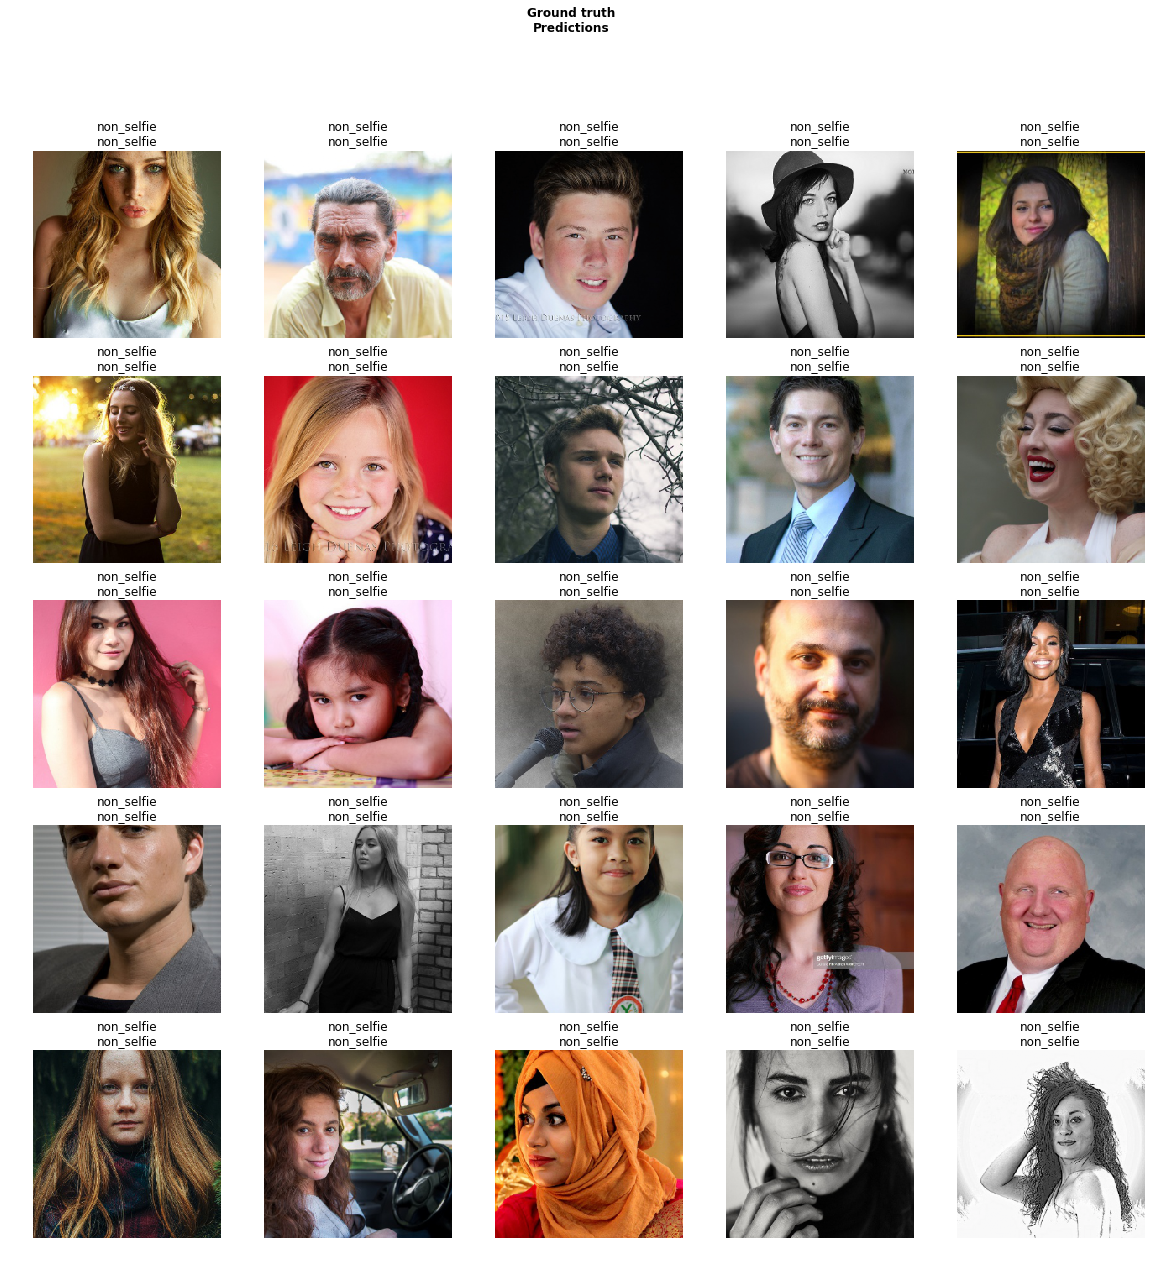

In [28]:
learn.show_results(data_test.valid_dl)

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

In [44]:
from fastai.widgets import *

First we need to get the file paths from our top_losses. We can do this with `.from_toplosses`. We then feed the top losses indexes and corresponding dataset to `ImageCleaner`.

Notice that the widget will not delete images directly from disk but it will create a new csv file `cleaned.csv` from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

In [48]:
ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Valid)

In [ ]:
ImageCleaner(ds, idxs)

'No images to show :)'

Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. `ImageCleaner` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses.ImageCleaner(ds, idxs)`

You can also find duplicates in your dataset and delete them! To do this, you need to run `.from_similars` to get the potential duplicates' ids and then run `ImageCleaner` with `duplicates=True`. The API works in a similar way as with misclassified images: just choose the ones you want to delete and click 'Next Batch' until there are no more images left.

In [ ]:
ds, idxs = DatasetFormatter().from_similars(learn, ds_type=DatasetType.Valid)

Getting activations...


Computing similarities...


In [50]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Remember to recreate your ImageDataBunch from your `cleaned.csv` to include the changes you made in your data!

## Putting your model in production

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [ ]:
import fastai
fastai.defaults.device = torch.device('cpu')

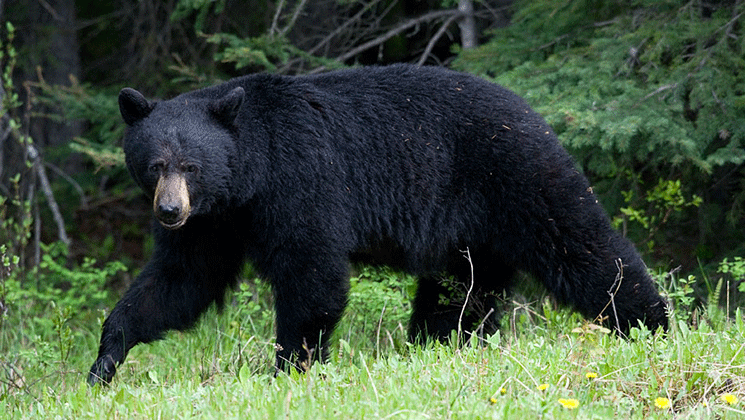

In [ ]:
img = open_image(path/'black'/'00000021.jpg')
img

In [ ]:
classes = ['black', 'grizzly', 'teddys']

In [ ]:
data2 = ImageDataBunch.single_from_classes(path, classes, tfms=get_transforms(), size=224).normalize(imagenet_stats)

In [ ]:
learn = create_cnn(data2, models.resnet34).load('stage-2')

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

'black'

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)

## Things that can go wrong

- Most of the time things will train fine with the defaults
- There's not much you really need to tune (despite what you've heard!)
- Most likely are
  - Learning rate
  - Number of epochs

### Learning rate (LR) too high

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(1, max_lr=0.5)

Total time: 00:13
epoch  train_loss  valid_loss  error_rate       
1      12.220007   1144188288.000000  0.765957    (00:13)



### Learning rate (LR) too low

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

Previously we had this result:

```
Total time: 00:57
epoch  train_loss  valid_loss  error_rate
1      1.030236    0.179226    0.028369    (00:14)
2      0.561508    0.055464    0.014184    (00:13)
3      0.396103    0.053801    0.014184    (00:13)
4      0.316883    0.050197    0.021277    (00:15)
```

In [ ]:
learn.fit_one_cycle(5, max_lr=1e-5)

Total time: 01:07
epoch  train_loss  valid_loss  error_rate
1      1.349151    1.062807    0.609929    (00:13)
2      1.373262    1.045115    0.546099    (00:13)
3      1.346169    1.006288    0.468085    (00:13)
4      1.334486    0.978713    0.453901    (00:13)
5      1.320978    0.978108    0.446809    (00:13)



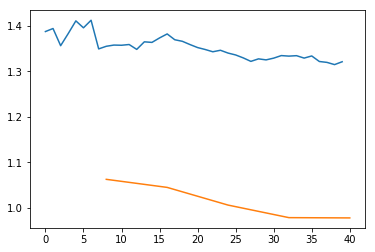

In [ ]:
learn.recorder.plot_losses()

As well as taking a really long time, it's getting too many looks at each image, so may overfit.

### Too few epochs

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, pretrained=False)

In [ ]:
learn.fit_one_cycle(1)

Total time: 00:14
epoch  train_loss  valid_loss  error_rate
1      0.602823    0.119616    0.049645    (00:14)



### Too many epochs

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=32, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
learn = create_cnn(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))

Total time: 06:39
epoch  train_loss  valid_loss  error_rate
1      1.513021    1.041628    0.507326    (00:13)
2      1.290093    0.994758    0.443223    (00:09)
3      1.185764    0.936145    0.410256    (00:09)
4      1.117229    0.838402    0.322344    (00:09)
5      1.022635    0.734872    0.252747    (00:09)
6      0.951374    0.627288    0.192308    (00:10)
7      0.916111    0.558621    0.184982    (00:09)
8      0.839068    0.503755    0.177656    (00:09)
9      0.749610    0.433475    0.144689    (00:09)
10     0.678583    0.367560    0.124542    (00:09)
11     0.615280    0.327029    0.100733    (00:10)
12     0.558776    0.298989    0.095238    (00:09)
13     0.518109    0.266998    0.084249    (00:09)
14     0.476290    0.257858    0.084249    (00:09)
15     0.436865    0.227299    0.067766    (00:09)
16     0.457189    0.236593    0.078755    (00:10)
17     0.420905    0.240185    0.080586    (00:10)
18     0.395686    0.255465    0.082418    (00:09)
19     0.373232    0.2